# Rain nowcasting


In [1]:
import glob

import numpy as np
from scipy.signal import convolve2d 

import torch
import torch.optim as optim

from tools import aimi_sl
from tools import NormGrad, NormDiv

import matplotlib.pyplot as plt

# Loading data

The four acquisitions used to compute motion:


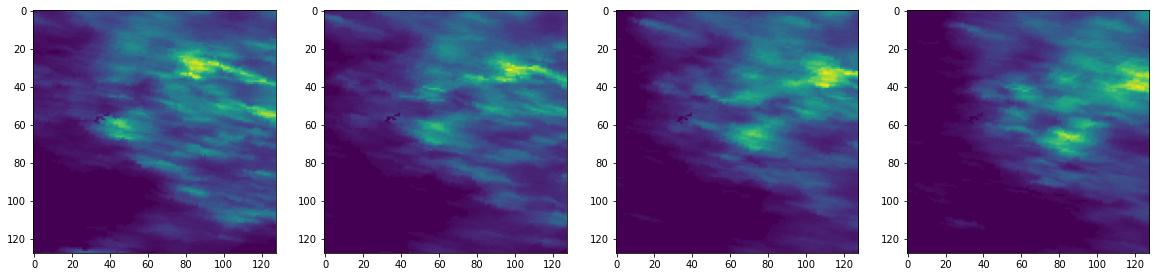

In [2]:
dir = "data/rain/"

files=sorted(glob.glob(dir+'/*.npz'))

def loadnpz(file):
    data = np.load(file)
    data = np.float32(list(data.values())[0])
#    data = np.flipud(data) # à virer ?
    return data

rainmaps = [loadnpz(f) for f in files]

print( 'The four acquisitions used to compute motion:')
plt.figure(figsize=(20,20))
plt.subplot(141)
plt.imshow(rainmaps[0])
plt.subplot(142)
plt.imshow(rainmaps[1])
plt.subplot(143)
plt.imshow(rainmaps[2])
plt.subplot(144)
plt.imshow(rainmaps[3])
plt.show()

# Motion Estimation with strong 4D-Var

In [3]:
# preprocessing 
mean5 = np.ones((5,5))/25.
Obs = torch.Tensor([convolve2d(img,mean5,'same') for img in rainmaps[:4]])

# Background
Qb = Obs[0]  
Ub, Vb = torch.zeros(Qb.shape), torch.zeros(Qb.shape)
Xb = torch.stack((Ub,Vb,Qb), dim=2)

# Observation
Obs = Obs[1:]

# Model parameters
dx = dy = 1200
dt = 60
Nf = 16 # number of time steps

# Covariances Matrices
Bm1 = torch.zeros(Xb.shape)
Bm1[:,:,2] = 0.01
thresh_im = 0.5    # rainfall threshold
Rm1 = torch.ones(Obs.shape)*25
Rm1[Obs<=thresh_im] = 0.04

# Regularization parameters
alpha = 5e9
beta = 5e6
maxiter = 300

# times for which an observation is available
tObs = [5, 10, 15]

# initialization of semi-Lagrangrian scheme
slag_model = aimi_sl(dx, dy, dt)

# 4D-Var algorithm
Ny, Nx = Obs[0].shape
Nv = 3

EpsB = torch.zeros(Xb.shape, requires_grad=True)
optimizer = optim.LBFGS([EpsB], lr=1, max_iter=maxiter)

def detach(a):
    return a.detach().numpy()

JL = []
def closure():
    optimizer.zero_grad()
    X = torch.empty(Nf,Ny,Nx,Nv)

    Jobs = Jq = 0

    # forward: time integration of X, computation of J_obs
    X[0] = Xb + EpsB
    for t in range(1, Nf):    
        X[t] = slag_model.step(X[t-1])
        if t in tObs:
            i = tObs.index(t)
            Dep = X[t,:,:,2] - Obs[i]
            Jobs += (Dep*Rm1[i]*Dep).sum()
            # optional, to improve performances see ...
            X[t,:,:,2] = Obs[tObs.index(t),:,:]

    # Background
    Dep = X[0] - Xb
    Jb = (Dep*Bm1*Dep).sum()

    # Regularization
    Jw = alpha*NormGrad(EpsB, dx, dy).sum()
    Jdiv = beta*NormDiv(EpsB, dx, dy).sum()

    J = 0.5*(Jb + Jobs + Jw + Jdiv)
    JL.append(detach(J))

#    print('J:', detach(J))
    J.backward(retain_graph=True)
    return J

optimizer.step(closure)
print('done')

# last forward
X = torch.empty(Nf,Ny,Nx,Nv)
X[0] = Xb + EpsB
for t in range(1, Nf):
    X[t] = slag_model.step(X[t-1])


done


# Results

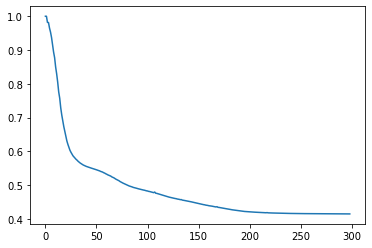

In [4]:
JL = np.array(JL)/JL[0]
Jp = JL[JL<=1]
plt.plot(Jp)
plt.show()


# Forecast


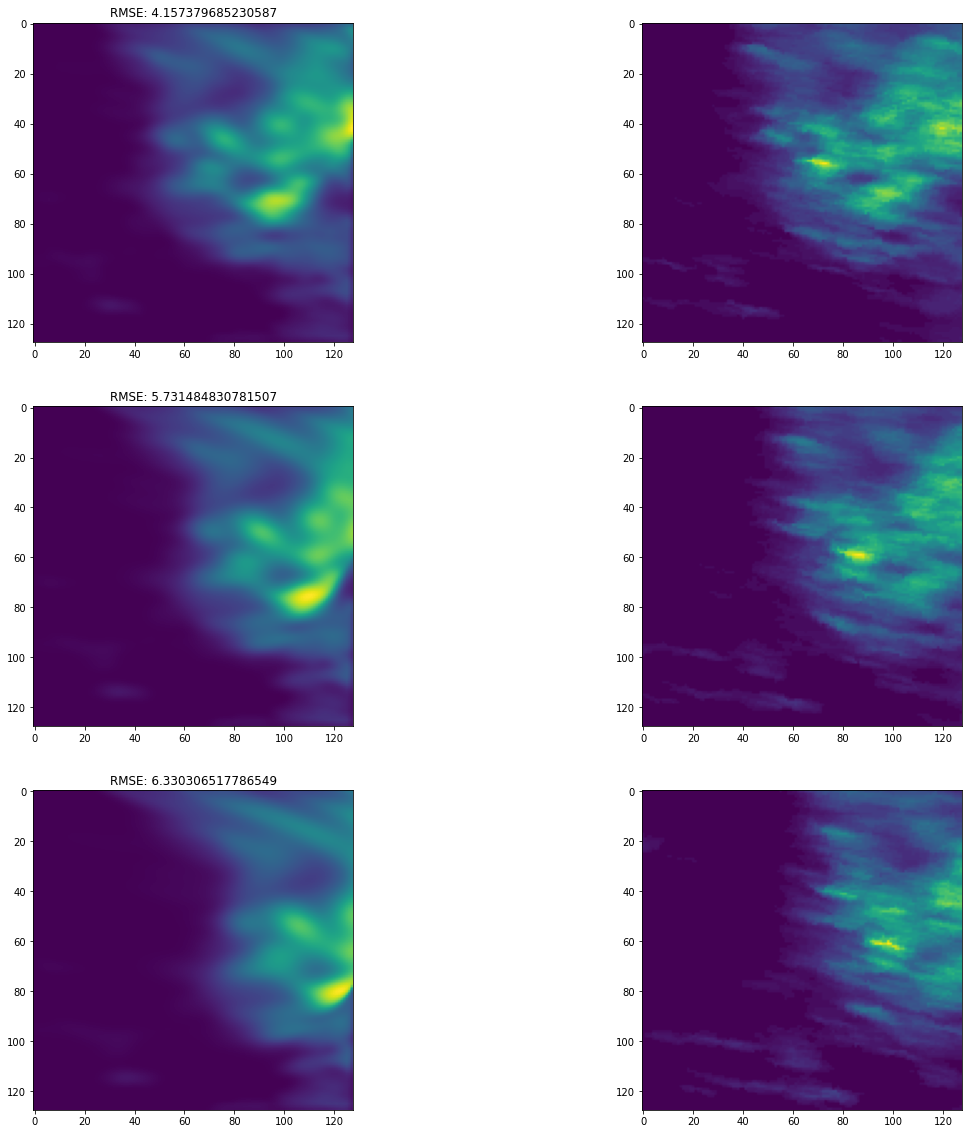

In [13]:
WRes = X[tObs[-1],:,:,:2]
LastObs = torch.Tensor(Obs[-1,:,:])

X0 = torch.stack((WRes[:,:,0],WRes[:,:,1],Obs[-1]), dim=2)
X_1 = torch.Tensor(X0)

Nf = 61
tObsForecast = [20, 40, 60]
slag_forecast = aimi_sl( dx, dy, 30, 5)

F = []
for t in range(1, Nf):
    X1 = slag_forecast.step(X0, Xm1=X_1)
    X0, X_1 = X1, X0
    if t in tObsForecast:
        F.append(detach(X1[:,:,2]))

plt.figure(figsize=(20,20))
plt.subplot(321)
plt.imshow(F[0])
plt.title('RMSE: '+str(np.mean((F[0]-rainmaps[4])**2)**0.5))
plt.subplot(322)
plt.imshow(rainmaps[4])
plt.subplot(323)
plt.imshow(F[1])
plt.title('RMSE: '+str(np.mean((F[1]-rainmaps[5])**2)**0.5))
plt.subplot(324)
plt.imshow(rainmaps[5])
plt.subplot(325)
plt.imshow(F[2])
plt.title('RMSE: '+str(np.mean((F[2]-rainmaps[6])**2)**0.5))
plt.subplot(326)
plt.imshow(rainmaps[6])
plt.show()